In [1]:
# Import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from keras import layers, activations
from keras.api.models import Sequential, load_model
from keras.api.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix
import warnings

warnings.filterwarnings('ignore')

2024-09-21 23:09:27.291267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 23:09:27.467183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 23:09:27.514227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-21 23:09:27.912182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-21 23:09:30.217953: W tensorflow/compiler/tf2

In [13]:
# We can customize the batch size, image height, and image width
batch_size  = 32
img_height  = 224
img_width   = 224
channel     = 3 # RGB

image_size              = (img_height, img_width)
image_size_with_channel = (img_height, img_width, channel)

# Constant value
CHECKPOINTS = "checkpoints"
LATEST_MODEL_NAME = "latest_model.keras"

In [15]:
# Save the current model
def save_model(model, model_name: str = ""):
    try:
        model.save(CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME)
    except Exception as e:
        print(e)
        raise e
    
    print("Model has succesfully saved")
    
def load_model_function(model_name):
    try:
        model_file = CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME
        model = load_model(model_file)

        return model
    except Exception as e:
        raise e

In [22]:
model = load_model_function()

I0000 00:00:1726497067.630775    3811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726497067.911115    3811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726497067.913450    3811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726497067.918360    3811 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [14]:
(train_ds, val_ds) = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/preprocessed_CLAHE",
    validation_split=0.2,
    subset="both",
    seed=69420,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2426 files belonging to 3 classes.
Using 1941 files for training.
Using 485 files for validation.


### Visualization

2024-09-21 23:12:33.172784: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


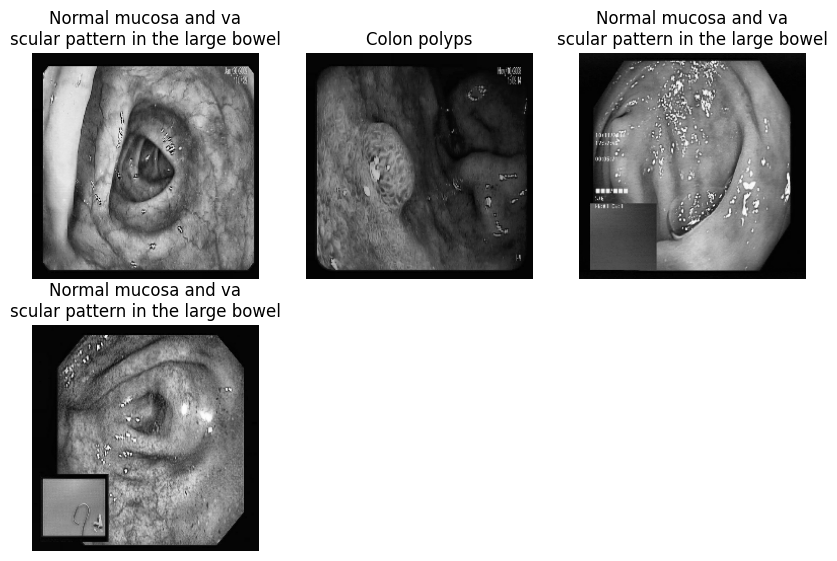

In [15]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]] if len(class_names[labels[i]]) < 20 else (class_names[labels[i]][:20]) + "\n" + (class_names[labels[i]][20:]))
        plt.axis("off")

In [16]:
augmentation = {
    "training": Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomFlip(),
    ]),

    "validation": Sequential([
    ]),
}

In [17]:
# Resnet
resnet_base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Densenet
densenet_base = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

In [18]:
resnet_base.trainable=True
densenet_base.trainable=True

for layer in resnet_base.layers[:-4]:
    layer.trainable=False
    
for layer in densenet_base.layers[:-4]:
    layer.trainable=False

In [19]:
inputs = keras.Input(shape=(224, 224, 3))
x = augmentation["training"](inputs)
x = keras.applications.densenet.preprocess_input(x)
x = densenet_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(units=3, activation=activations.softmax)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    20,873,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,517,123 (127.86 MB)

 Trainable params: 20,914,435 (79.78 MB)

 Non-trainable params: 12,602,688 (48.08 MB)

In [20]:
model.compile(
    optimizer="adam",
    loss=tf._losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [21]:
def get_early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

early_stopping = get_early_stopping()

callbacks = [early_stopping]

In [22]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=30, callbacks=callbacks)

Epoch 1/30


2024-09-21 23:13:12.802288: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1726935192.986754   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935193.064276   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935193.105600   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935193.156837   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935193.206812   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935193.240371   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935193.255115   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935193.271077   12326 gpu_t

 1/61 ━━━━━━━━━━━━━━━━━━━━ 23:22 23s/step - accuracy: 0.5312 - loss: 2.1246

W0000 00:00:1726935198.827947   12329 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935198.835872   12329 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935198.842832   12329 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935198.845031   12329 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935198.849209   12329 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935198.857737   12329 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935198.859852   12329 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935198.862053   12329 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935198.863804   12329 gp

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5858 - loss: 64.7018

W0000 00:00:1726935216.766411   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935216.769709   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935216.772830   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935216.776417   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935216.780011   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935216.785260   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935216.791842   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935216.797649   12326 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935216.804898   12326 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.5866 - loss: 64.3307

W0000 00:00:1726935221.265505   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935221.267112   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935221.268858   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935221.270478   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935221.271987   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935221.273404   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935229.955845   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935229.957719   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935229.959449   12328 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 57s 567ms/step - accuracy: 0.5875 - loss: 63.9715 - val_accuracy: 0.7670 - val_loss: 14.6550
Epoch 2/30


W0000 00:00:1726935232.778941   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935232.780472   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935232.781948   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935232.783364   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935232.784914   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935232.786386   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935232.792993   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935232.794569   12328 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726935232.796002   12328 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.7506 - loss: 15.1389 - val_accuracy: 0.7361 - val_loss: 11.1084
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7677 - loss: 12.2692 - val_accuracy: 0.8021 - val_loss: 11.2653
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.7431 - loss: 13.5655 - val_accuracy: 0.7340 - val_loss: 13.0050
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.7645 - loss: 9.9947 - val_accuracy: 0.7856 - val_loss: 13.0547
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.7572 - loss: 9.6529 - val_accuracy: 0.7196 - val_loss: 8.0629
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 375ms/step - accuracy: 0.7715 - loss: 4.8781 - val_accuracy: 0.8124 - val_loss: 7.0332
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - accuracy: 0.7909 - loss: 4.4693 - val_accuracy: 0.7691 - val_loss: 4.9320
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.7761 - loss: 3.3923 - val_accuracy

In [23]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])
     

print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Confusion Matrix
[[128   0  34]
 [ 20   3   3]
 [ 40   0 257]]


In [16]:
save_model(model=model, model_name="densenet_169_")

Model has succesfully saved
